<a href="https://colab.research.google.com/github/zaneho/TransferLearning-Monkey/blob/master/FirstProject(TransferLearning_Monkey).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monkey Project
We want to train a model that can tell the difference between 10 different 
Monkey species

To do this we are going to use a famous Imagenet model called InceptionV3 to do transfer Learning.

Along the way will also use the new tf.data along with Pandas to handle the input pipelines for training and testing.


In [1]:
!ls

sample_data


# Test for GPU

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Download the data
https://www.dropbox.com/s/je25ylpp8r1r8uc/10-monkey-species.zip

In [3]:
!wget -qq https://www.dropbox.com/s/vj61417lofjebju/utils.zip
!wget -qq https://www.dropbox.com/s/je25ylpp8r1r8uc/10-monkey-species.zip


!unzip -qq 10-monkey-species.zip
!rm 10-monkey-species.zip

!unzip -qq utils.zip
!rm utils.zip


!ls

gdrive.py  monkey_labels.txt  sutils.py     validation.zip
__MACOSX   sample_data	      training.zip


In [4]:
!unzip -qq training.zip
!rm training.zip

!unzip -qq validation.zip
!rm validation.zip

!ls

gdrive.py  monkey_labels.txt  sutils.py  validation
__MACOSX   sample_data	      training


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt


from sutils import *
import os, json
from glob import glob
import numpy as np

import keras

from tensorflow.keras import optimizers

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16


from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.models import Model,load_model,Sequential

from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.python.keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, Callback


Using TensorFlow backend.


In [6]:
print(tf.__version__)
print(tf.keras.__version__)
print(keras.__version__)

1.12.0
2.1.6-tf
2.2.4


In [7]:
!ls training

n0  n1	n2  n3	n4  n5	n6  n7	n8  n9


In [0]:
# Set up some Hyperparameters

batch_size = 32
epochs = 10

lr = 0.001

## Converting raw files in folders into something we can feed into tf.data

We use glob to get lists of the files in the directories and then convert them into dataframes and add in class numbers.


Finally we randomly shuffle them up


In [9]:
import glob
import pandas as pd

#the groups
filenames_n0 = glob.glob('./training/n0/*.jpg')
filenames_n1 = glob.glob('./training/n1/*.jpg')
filenames_n2 = glob.glob('./training/n2/*.jpg')
filenames_n3 = glob.glob('./training/n3/*.jpg')
filenames_n4 = glob.glob('./training/n4/*.jpg')
filenames_n5 = glob.glob('./training/n5/*.jpg')
filenames_n6 = glob.glob('./training/n6/*.jpg')
filenames_n7 = glob.glob('./training/n7/*.jpg')
filenames_n8 = glob.glob('./training/n8/*.jpg')
filenames_n9 = glob.glob('./training/n9/*.jpg')

names = ['alouatta_palliata', 'erythrocebus_patas','cacajao_calvus','macaca_fuscata','cebuella_pygmea'
         ,'cebus_capucinus','mico_argentatus','saimiri_sciureus','aotus_nigriceps','trachypithecus_johnii']


len(filenames_n0)



105

In [10]:
# Make a dataframe based on the filenames
df = pd.DataFrame(filenames_n0, columns = ["filename"])
df2 = pd.DataFrame(filenames_n1, columns = ["filename"])
df3 = pd.DataFrame(filenames_n2, columns = ["filename"])
df4 = pd.DataFrame(filenames_n3, columns = ["filename"])
df5 = pd.DataFrame(filenames_n4, columns = ["filename"])
df6 = pd.DataFrame(filenames_n5, columns = ["filename"])
df7 = pd.DataFrame(filenames_n6, columns = ["filename"])
df8 = pd.DataFrame(filenames_n7, columns = ["filename"])
df9 = pd.DataFrame(filenames_n8, columns = ["filename"])
df10 = pd.DataFrame(filenames_n9, columns = ["filename"])

df.head()

,filename
0,./training/n0/n0174.jpg
1,./training/n0/n0142.jpg
2,./training/n0/n0139.jpg
3,./training/n0/n0032.jpg
4,./training/n0/n0021.jpg


In [11]:

# Add Class columns 
df['class'] = pd.Series([0 for x in range(len(df.index))], index=df.index)
df2['class'] = pd.Series([1 for x in range(len(df2.index))], index=df2.index)
df3['class'] = pd.Series([2 for x in range(len(df3.index))], index=df3.index)
df4['class'] = pd.Series([3 for x in range(len(df4.index))], index=df4.index)
df5['class'] = pd.Series([4 for x in range(len(df5.index))], index=df5.index)
df6['class'] = pd.Series([5 for x in range(len(df6.index))], index=df6.index)
df7['class'] = pd.Series([6 for x in range(len(df7.index))], index=df7.index)
df8['class'] = pd.Series([7 for x in range(len(df8.index))], index=df8.index)
df9['class'] = pd.Series([8 for x in range(len(df9.index))], index=df9.index)
df10['class'] = pd.Series([9 for x in range(len(df10.index))], index=df10.index)

df.head()

,filename,class
0,./training/n0/n0174.jpg,0
1,./training/n0/n0142.jpg,0
2,./training/n0/n0139.jpg,0
3,./training/n0/n0032.jpg,0
4,./training/n0/n0021.jpg,0


In [0]:
# Split into train and validation sets
train_set_percentage = .9


train_df = df[:int(len(df)*train_set_percentage)]
val_df = df[int(len(df)*train_set_percentage):]

train_df2 = df2[:int(len(df2)*train_set_percentage)]
val_df2 = df2[int(len(df2)*train_set_percentage):]

train_df3 = df3[:int(len(df3)*train_set_percentage)]
val_df3 = df3[int(len(df3)*train_set_percentage):]

train_df4 = df4[:int(len(df4)*train_set_percentage)]
val_df4 = df4[int(len(df4)*train_set_percentage):]

train_df5 = df5[:int(len(df5)*train_set_percentage)]
val_df5 = df5[int(len(df5)*train_set_percentage):]

train_df6 = df6[:int(len(df6)*train_set_percentage)]
val_df6 = df6[int(len(df6)*train_set_percentage):]

train_df7 = df7[:int(len(df7)*train_set_percentage)]
val_df7 = df7[int(len(df7)*train_set_percentage):]

train_df8 = df8[:int(len(df8)*train_set_percentage)]
val_df8 = df8[int(len(df8)*train_set_percentage):]

train_df9 = df9[:int(len(df9)*train_set_percentage)]
val_df9 = df9[int(len(df9)*train_set_percentage):]

train_df10 = df10[:int(len(df10)*train_set_percentage)]
val_df10 = df10[int(len(df10)*train_set_percentage):]





df_new_train = pd.concat([train_df, train_df2, train_df3, train_df4, train_df5, train_df6, train_df7, train_df8, train_df9, train_df10])
df_new_val = pd.concat([val_df, val_df2, val_df3, val_df4, val_df5, val_df6, val_df7, val_df8, val_df9, val_df10])

df_new_train.shape

#shuffle
df = df_new_train.sample(frac=1).reset_index(drop=True)
df_val = df_new_val.sample(frac=1).reset_index(drop=True)

# Examine the Dataset

lets look at what we have now. 

In [13]:
df.head()

,filename,class
0,./training/n6/n6037.jpg,6
1,./training/n4/n4138.jpg,4
2,./training/n0/n0169.jpg,0
3,./training/n1/n1026.jpg,1
4,./training/n1/n1165.jpg,1


In [14]:
#training - 1096 row, 2 col (filename & class)
#validation - 272 row, 2 col (filename & class)
print(df.shape)
print(df_val.shape)

df['class'].unique()

(981, 2)
(115, 2)


array([6, 4, 0, 1, 2, 9, 7, 3, 5, 8])

3    109
7    102
5    101
2     99
1     99
8     95
6     95
4     94
0     94
9     93
Name: class, dtype: int64


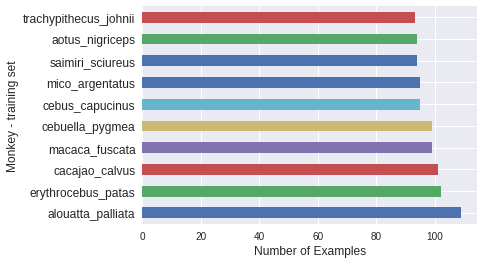

In [15]:
print(df['class'].value_counts())


ax = df['class'].value_counts().plot.barh()
ax.set_xlabel("Number of Examples", fontsize=12)
ax.set_ylabel("Monkey - training set", fontsize=12)


names = ['alouatta_palliata', 'erythrocebus_patas','cacajao_calvus','macaca_fuscata','cebuella_pygmea'
         ,'cebus_capucinus','mico_argentatus','saimiri_sciureus','aotus_nigriceps','trachypithecus_johnii']

ax.set_yticklabels(names, rotation=0, fontsize=12)



plt.show()

In [16]:
# convert the dataframe into 2 lists to use for filename and labels
train_filenames_list = df["filename"].tolist()
train_labels_list = df["class"].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
val_filenames_list = df_val["filename"].tolist()
val_labels_list = df_val["class"].astype('int32').tolist()

#number of classes
num_classes = 10

df.shape

(981, 2)

## Make the pipeline for loading and resizing the images

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 299,299

def _parse_function(filename, label):
  image_string = tf.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_resized = tf.image.resize_images(image_decoded, [img_rows, img_cols])
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [0]:
# A vector of filenames - from a list
filenames = tf.constant(train_filenames_list)

# Labels that match the training files - from a list
labels = tf.constant(train_labels_list)

# Same as above but for validation set
val_filenames = tf.constant(val_filenames_list)
val_labels = tf.constant(val_labels_list)


## Assembling the Data pipeline using tf.data

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.repeat(100)
train_dataset = train_dataset.batch(23)

In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat(100)
valid_dataset = valid_dataset.batch(23)

In [0]:
test_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.repeat(1)
test_dataset = test_dataset.batch(115)

## Create the network

In [22]:
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 8s 0us/step


In [23]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

## Create a simple head for the model that we can train

In [0]:

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)


# 5 Classes for flowers
predictions = Dense(num_classes, activation='softmax')(x)


In [0]:
# Creating the model that we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [26]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    if 'batch' in layer.name:
      print(layer.name)
      layer.trainable = True
    else:
      layer.trainable = False 


batch_normalization
batch_normalization_1
batch_normalization_2
batch_normalization_3
batch_normalization_4
batch_normalization_8
batch_normalization_6
batch_normalization_9
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
batch_normalization_15
batch_normalization_13
batch_normalization_16
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
batch_normalization_22
batch_normalization_20
batch_normalization_23
batch_normalization_19
batch_normalization_21
batch_normalization_24
batch_normalization_25
batch_normalization_27
batch_normalization_28
batch_normalization_26
batch_normalization_29
batch_normalization_34
batch_normalization_35
batch_normalization_31
batch_normalization_36
batch_normalization_32
batch_normalization_37
batch_normalization_30
batch_normalization_33
batch_normalization_38
batch_normalization_39
batch_normalization_44
batch_normalization_45
batch_normalization_41
batch_normalization_46


In [27]:
for layer in model.layers:
    print(layer.name)
    print(layer.trainable)

input_1
False
conv2d
False
batch_normalization
True
activation
False
conv2d_1
False
batch_normalization_1
True
activation_1
False
conv2d_2
False
batch_normalization_2
True
activation_2
False
max_pooling2d
False
conv2d_3
False
batch_normalization_3
True
activation_3
False
conv2d_4
False
batch_normalization_4
True
activation_4
False
max_pooling2d_1
False
conv2d_8
False
batch_normalization_8
True
activation_8
False
conv2d_6
False
conv2d_9
False
batch_normalization_6
True
batch_normalization_9
True
activation_6
False
activation_9
False
average_pooling2d
False
conv2d_5
False
conv2d_7
False
conv2d_10
False
conv2d_11
False
batch_normalization_5
True
batch_normalization_7
True
batch_normalization_10
True
batch_normalization_11
True
activation_5
False
activation_7
False
activation_10
False
activation_11
False
mixed0
False
conv2d_15
False
batch_normalization_15
True
activation_15
False
conv2d_13
False
conv2d_16
False
batch_normalization_13
True
batch_normalization_16
True
activation_13
False
act

## Select an Optimizer 

In [0]:
# creates the optimizer using a tensorFlow optimizer with lr setting the Learning Rate

# tf.keras optimizer
opt = optimizers.Adam(lr)

# We could use a TensorFlow Optimizer but they can't save the weight as a whole
# opt = tf.train.AdamOptimizer(lr)

## Compile the model

In [0]:
# compile the model 

model.compile(optimizer= opt, loss='categorical_crossentropy',metrics=['accuracy'])

## Call backs

In [0]:
!mkdir checkpoints


checkpoint = ModelCheckpoint('./checkpoints/weights_{epoch:02d}_{val_acc:.2f}.hdf5', verbose=1, save_best_only=True, mode='auto')

In [0]:
train_steps = 50
val_steps = 50
epochs = 5

## Fit the model

we pass in:
- The training set
- the steps for how many times we want to sample a batch to be one epoch
- number of epochs
- validation set
- number of steps for validation

In [32]:
# # Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[checkpoint])

Epoch 1/5
49/50 [============================>.] - ETA: 1s - loss: 0.8486 - acc: 0.7445
Epoch 00001: val_loss improved from inf to 0.80504, saving model to ./checkpoints/weights_01_0.75.hdf5
50/50 [==============================] - 124s 2s/step - loss: 0.8388 - acc: 0.7461 - val_loss: 0.8050 - val_acc: 0.7478
Epoch 2/5
49/50 [============================>.] - ETA: 0s - loss: 0.1335 - acc: 0.9574
Epoch 00002: val_loss improved from 0.80504 to 0.10141, saving model to ./checkpoints/weights_02_0.97.hdf5
50/50 [==============================] - 72s 1s/step - loss: 0.1346 - acc: 0.9565 - val_loss: 0.1014 - val_acc: 0.9652
Epoch 3/5
49/50 [============================>.] - ETA: 0s - loss: 0.0848 - acc: 0.9725
Epoch 00003: val_loss improved from 0.10141 to 0.07759, saving model to ./checkpoints/weights_03_0.97.hdf5
50/50 [==============================] - 72s 1s/step - loss: 0.0831 - acc: 0.9730 - val_loss: 0.0776 - val_acc: 0.9739
Epoch 4/5
49/50 [============================>.] - ETA: 0s - 

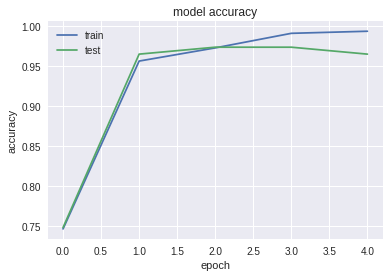

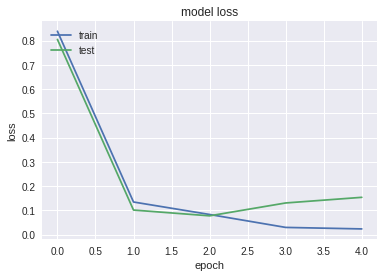

In [33]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [34]:
# # Train the model with validation 
history = model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[checkpoint])

Epoch 1/5
49/50 [============================>.] - ETA: 0s - loss: 0.0271 - acc: 0.9911
Epoch 00001: val_loss did not improve from 0.07759
50/50 [==============================] - 71s 1s/step - loss: 0.0267 - acc: 0.9913 - val_loss: 0.1108 - val_acc: 0.9652
Epoch 2/5
49/50 [============================>.] - ETA: 0s - loss: 0.0088 - acc: 1.0000
Epoch 00002: val_loss did not improve from 0.07759
50/50 [==============================] - 72s 1s/step - loss: 0.0088 - acc: 1.0000 - val_loss: 0.1097 - val_acc: 0.9826
Epoch 3/5
49/50 [============================>.] - ETA: 0s - loss: 0.0070 - acc: 1.0000
Epoch 00003: val_loss did not improve from 0.07759
50/50 [==============================] - 72s 1s/step - loss: 0.0069 - acc: 1.0000 - val_loss: 0.1309 - val_acc: 0.9739
Epoch 4/5
49/50 [============================>.] - ETA: 0s - loss: 0.0148 - acc: 0.9938
Epoch 00004: val_loss did not improve from 0.07759
50/50 [==============================] - 72s 1s/step - loss: 0.0149 - acc: 0.9939 - val

In [35]:
!ls checkpoints

weights_01_0.75.hdf5  weights_02_0.97.hdf5  weights_03_0.97.hdf5


In [36]:
metrics = model.evaluate(valid_dataset,steps=50)
print("model accuracy:",metrics[1])

50/50 [==============================] - 26s 521ms/step
model accuracy: 0.973913049697876


In [0]:
model.load_weights('./checkpoints/weights_03_0.97.hdf5')

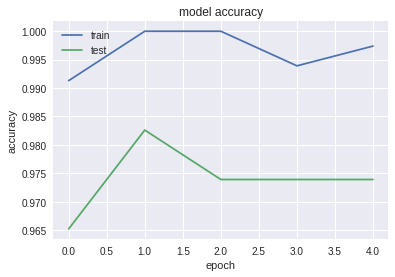

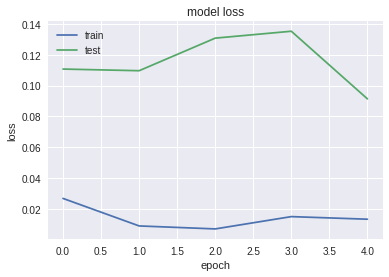

In [37]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Make some predictions


In [39]:
preds = model.predict(valid_dataset,steps=5)
preds = preds.argmax(axis=-1)

preds.shape

(115,)

In [0]:
val_labels = val_labels_list[0:320]


In [41]:
len(val_labels)

115

## Make a Confusion Matrix


In [0]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(val_labels,preds)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



Normalized confusion matrix
[[0.90909091 0.         0.         0.         0.         0.
  0.         0.         0.09090909 0.        ]
 [0.         0.91666667 0.         0.         0.         0.
  0.         0.         0.08333333 0.        ]
 [0.         0.         1.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.91666667 0.08333333 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.        ]
 [0.     

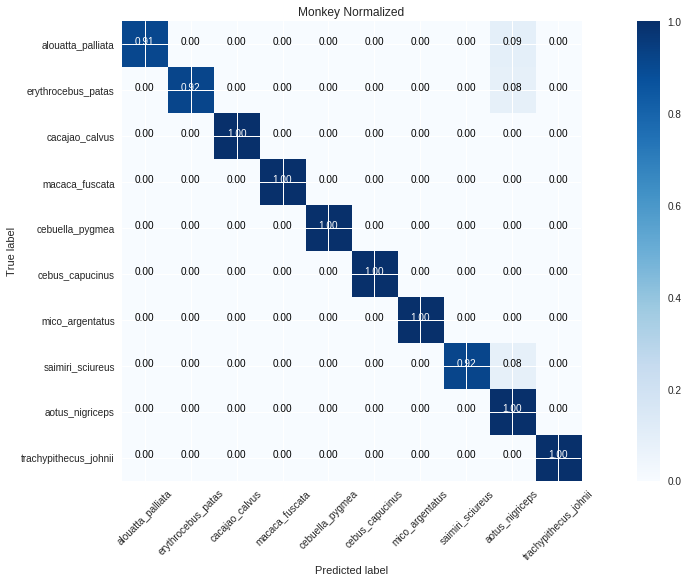

In [44]:
cm_plot_labels = names

# # Plot normalized confusion matrix
plt.figure(figsize=(16,8))
plot_confusion_matrix(cm, cm_plot_labels, normalize=True,
                      title='Monkey Normalized')

plt.show()

## Make some predictions


In [45]:
!ls

checkpoints  __MACOSX		__pycache__  sutils.py	validation
gdrive.py    monkey_labels.txt	sample_data  training


In [0]:
image_path = './validation/'


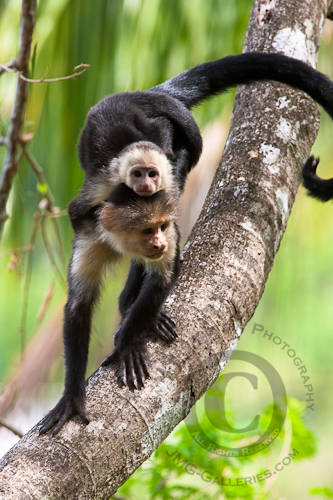

In [47]:
from IPython.display import Image

image_name = 'n5/n500.jpg'
Image(image_path+image_name)

In [48]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
import numpy as np

img_path = os.path.join(image_path, image_name)
img = image.load_img(img_path, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
print('Input image shape:', x.shape)

Input image shape: (1, 299, 299, 3)


In [49]:
pred = model.predict(x)
print('Predicted:', pred)

print(np.argmax(pred))

Predicted: [[3.5922412e-02 1.5111899e-05 5.2671214e-05 1.4853434e-04 2.9812058e-04
  9.5019561e-01 6.1569287e-04 1.6476671e-03 9.6441731e-03 1.4599805e-03]]
5


In [50]:
result= np.argmax(pred)
if result==0:
    print("Its a alouatta_palliata")
elif result==1:
    print("Its a erythrocebus_patas")
elif result==2:
    print("Its a cacajao_calvus")
elif result==3:
    print("Its a macaca_fuscata")
elif result==4:
    print("Its a cebuella_pygmea")
elif result==5:
    print("Its a cebus_capucinus")
elif result==6:
    print("Its a mico_argentatus")
elif result==7:
    print("Its a saimiri_sciureus")
elif result==8:
    print("Its a aotus_nigriceps")
elif result==9:
    print("Its a trachypithecus_johnii")
    

Its a cebus_capucinus
